In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import csv
import pickle
import operator
import datetime
import os

# Data Exploration

In [2]:
df = pd.read_csv(f'./train-item-views.csv', sep=";") #input csv file

In [3]:
#removing NaN userID
df = df[df["userId"].notnull()]
df.shape

(372991, 5)

In [4]:
df.describe()

,sessionId,userId,itemId,timeframe
count,372991.00000,372991.000000,372991.000000,3.729910e+05
mean,228014.36743,86963.792668,67981.901756,3.477112e+05
std,163459.09220,65592.218564,86736.685575,3.194243e+05
min,48.00000,2.000000,1.000000,1.200000e+01
25%,89403.50000,30832.000000,12726.000000,8.047450e+04
50%,199385.00000,71553.000000,35874.000000,2.419360e+05
75%,349353.00000,132402.000000,82549.000000,5.438415e+05
max,600687.00000,249347.000000,733848.000000,1.199992e+06


In [5]:
#example of raw data
df.head()

,sessionId,userId,itemId,timeframe,eventdate
164,48,2.0,24764,8863,2016-04-09
165,48,2.0,24764,496381,2016-04-09
166,48,2.0,24764,265216,2016-04-09
167,48,2.0,24764,519975,2016-04-09
168,48,2.0,24764,456437,2016-04-09


In [6]:
df.shape

(372991, 5)

In [7]:
#removing NaN userID
df = df[df["userId"].notnull()]

In [8]:
#number of sessions
df['sessionId'].value_counts()

sessionId
129618    81
583862    78
167893    62
100675    57
328760    56
          ..
80613      1
80642      1
358447     1
80649      1
600687     1
Name: count, Length: 94106, dtype: int64

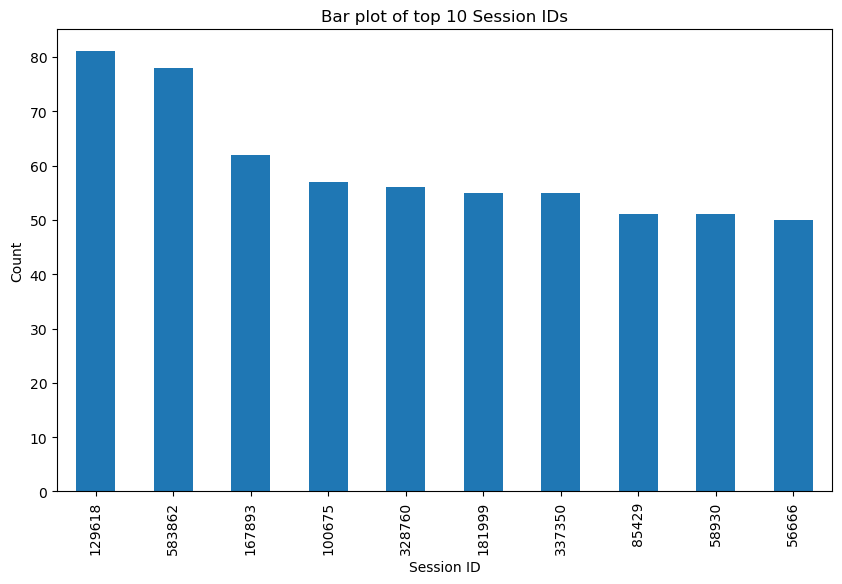

In [9]:
# Get the top 10 session ids
top_10_session_ids = df['sessionId'].value_counts().head(10)

# Plot
plt.figure(figsize=(10,6)) # Change the figure size as per your needs
top_10_session_ids.plot(kind='bar')
plt.title('Bar plot of top 10 Session IDs')
plt.xlabel('Session ID')
plt.ylabel('Count')
plt.show()

In [10]:
average_value_counts = df['sessionId'].value_counts().mean()
print(f'The average value count of the session ID is: {average_value_counts}')

The average value count of the session ID is: 3.963519860582747


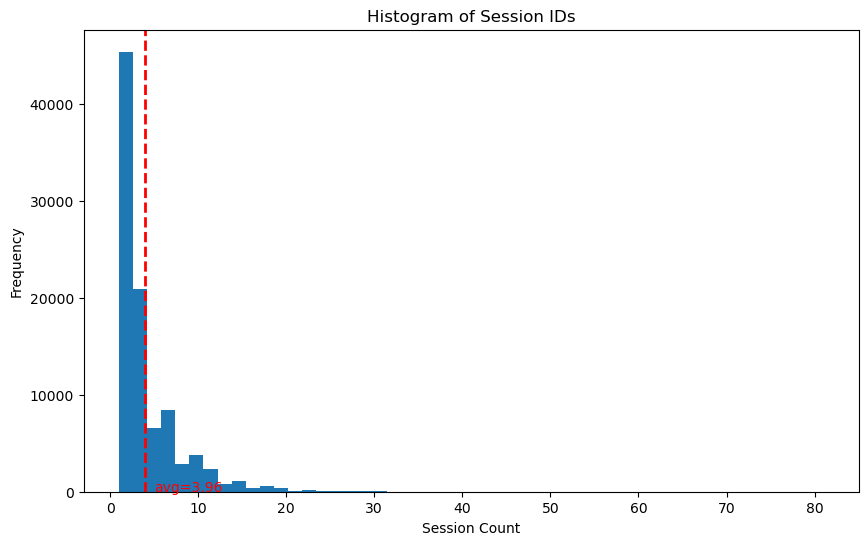

In [11]:
value_counts = df['sessionId'].value_counts()

# Calculate average
average_value_counts = value_counts.mean()

# Plot
plt.figure(figsize=(10,6)) # Change the figure size as per your needs
plt.hist(value_counts, bins=50) # change bins as per your needs
plt.axvline(average_value_counts, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of Session IDs')
plt.xlabel('Session Count')
plt.ylabel('Frequency')
plt.text(average_value_counts+1, 0, 'avg={:.2f}'.format(average_value_counts), color = 'r')
plt.show()

In [12]:
#count unique session per user
unique_session_counts = df.groupby('userId')['sessionId'].nunique()
unique_session_counts_df = unique_session_counts.reset_index()
unique_session_counts_df.columns = ['userId', 'uniqueSessionCount']
unique_session_counts_df.sort_values('uniqueSessionCount', ascending=False, inplace=True)

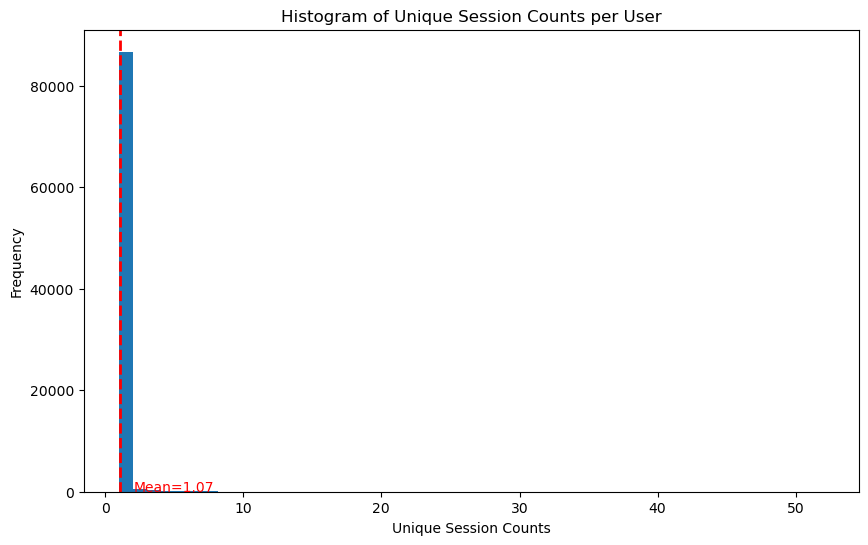

In [13]:
# Calculate the mean
mean_unique_session_counts = unique_session_counts_df['uniqueSessionCount'].mean()

# Plot
plt.figure(figsize=(10,6)) # Change the figure size as per your needs
plt.hist(unique_session_counts_df['uniqueSessionCount'], bins=50) # change bins as per your needs
plt.axvline(mean_unique_session_counts, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of Unique Session Counts per User')
plt.xlabel('Unique Session Counts')
plt.ylabel('Frequency')
plt.text(mean_unique_session_counts+1, 0, 'Mean={:.2f}'.format(mean_unique_session_counts), color = 'r')
plt.show()

In [14]:
items_per_session = df.groupby('sessionId')['itemId'].nunique()

items_per_session_df = items_per_session.reset_index()
items_per_session_df.columns = ['sessionId', 'uniqueItemCount']
items_per_session_df.sort_values('uniqueItemCount', ascending=False, inplace=True)

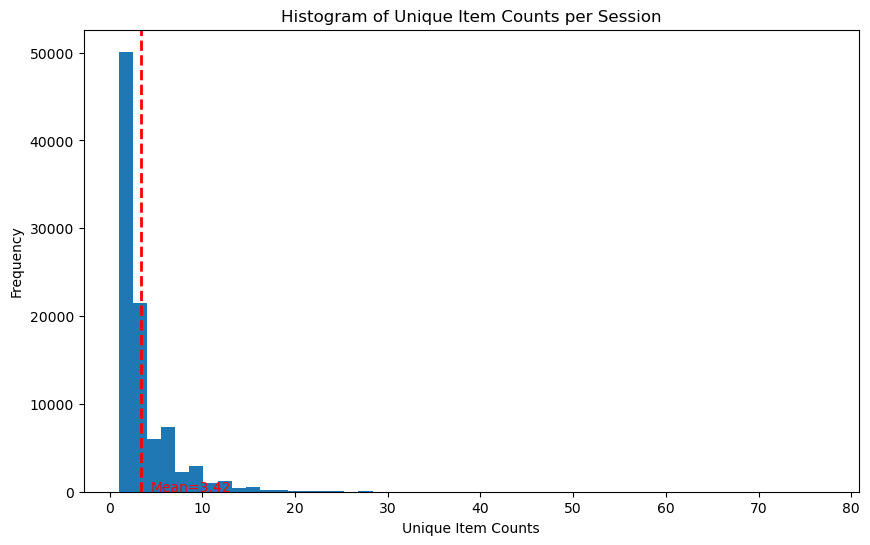

In [15]:
# Calculate the mean
mean_unique_item_counts = items_per_session_df['uniqueItemCount'].mean()

# Plot
plt.figure(figsize=(10,6)) # Change the figure size as per your needs
plt.hist(items_per_session_df['uniqueItemCount'], bins=50) # change bins as per your needs
plt.axvline(mean_unique_item_counts, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of Unique Item Counts per Session')
plt.xlabel('Unique Item Counts')
plt.ylabel('Frequency')
plt.text(mean_unique_item_counts+1, 0, 'Mean={:.2f}'.format(mean_unique_item_counts), color = 'r')
plt.show()

# Data Preprocessing

In [16]:
min_len = 2
min_count = 5

## Adding Timestamp

In [17]:
def add_time_feature(data):
  data['time'] = data["eventdate"].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').timestamp())
  data['timeframe'] = data['timeframe'].apply(lambda x: (x / 1000))

  del(data["eventdate"])
  return data

In [18]:
df_timestamp = add_time_feature(df)

## Deleting rare items and short sessions

In [19]:
def remove_short_sessions(data, min_len):
  sessionLen = data.groupby('sessionId').size()
  mask = np.in1d(data['sessionId'], sessionLen[sessionLen >= min_len].index)
  data = data[mask]
  return data

In [20]:
df_filter = remove_short_sessions(df_timestamp, min_len)

In [21]:
def remove_rare_items (data, min_count):
  item_supports = data.groupby('itemId').size()
  mask = np.in1d(data['itemId'], item_supports[item_supports >= min_count].index)
  data = data[mask]
  return data

In [22]:
df_filter2 = remove_rare_items(df_filter, min_count)

In [23]:
df_filter2 = remove_short_sessions(df_filter2, min_len)

## Remove users with few sessions

In [24]:
#get how many sessions each UserID has
count_session = df_filter2.groupby(["userId"])['sessionId'].nunique().reset_index(name='counts')

In [25]:
#get userID with number of session > 3
count_session = count_session[count_session['counts'] > 3]

In [26]:
len(count_session)

314

In [27]:
#remove userID that has less than 4 session (could change this)
df_filter3 = df_filter2[df_filter2["userId"].isin(count_session['userId'].values.tolist())]

## Split for each client

In [28]:
#recode the UserID
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(df_filter3['userId'])
df_filter3['userId2'] = le.transform(df_filter3['userId'])

C:\Users\IME-LAB\AppData\Local\Temp\ipykernel_1904\1275722919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter3['userId2'] = le.transform(df_filter3['userId'])


In [29]:
max_user = df_filter3['userId2'].max()
max_user

313

In [30]:
data = [0 for i in range(max_user + 1)]

In [31]:
#seperate based on clientID
for i in range(max_user + 1):
    data[i] = df_filter3[df_filter3['userId2'] == i]

## Splitting last day

In [32]:
def get_test_data(data):
  t_max = data['time'].max()
  session_times = data.groupby('sessionId')['time'].max()
  splitdate = t_max - 86400 * 7

  train_ids = session_times[session_times < splitdate].index
  test_ids = session_times[session_times > splitdate].index

  before_last_day = data[np.in1d(data['sessionId'], train_ids)]
  last_day = data[np.in1d(data['sessionId'], test_ids)]

  return before_last_day, last_day

In [33]:
train_data = []
test_data = []
for i in range(max_user + 1):
  tr_data, ts_data = get_test_data(data[i])
  train_data.append(tr_data)
  test_data.append(ts_data)

## Removing non-common items from test set

In [34]:
def remove_non_common_items(data, test_data):
  mask = np.in1d(test_data['itemId'], data['itemId'])
  test_data = test_data[mask]
  return test_data

In [35]:
for i in range(max_user + 1):
    test_data[i] = remove_non_common_items(train_data[i], test_data[i])
    test_data[i] = remove_short_sessions(test_data[i], min_len)

len(test_data)

314

In [36]:
test_data[2]

,sessionId,userId,itemId,timeframe,time,userId2


In [37]:
# assuming test_data is your list of DataFrames
user_non_empty_test = []
for i, df in enumerate(test_data):
    if not df.empty:
      user_non_empty_test.append(i)

print(f"count non missing: {len(user_non_empty_test)}")

count non missing: 45


In [38]:
# assuming train is your list of DataFrames
user_non_empty_train = []
for i, df in enumerate(train_data):
    if not df.empty:
      print(f"The DataFrame at index {i} has no missing values")
      user_non_empty_train.append(i)

print(f"count non missing: {len(user_non_empty_train)}")

The DataFrame at index 0 has no missing values
The DataFrame at index 1 has no missing values
The DataFrame at index 2 has no missing values
The DataFrame at index 3 has no missing values
The DataFrame at index 4 has no missing values
The DataFrame at index 5 has no missing values
The DataFrame at index 6 has no missing values
The DataFrame at index 7 has no missing values
The DataFrame at index 8 has no missing values
The DataFrame at index 9 has no missing values
The DataFrame at index 10 has no missing values
The DataFrame at index 11 has no missing values
The DataFrame at index 12 has no missing values
The DataFrame at index 13 has no missing values
The DataFrame at index 14 has no missing values
The DataFrame at index 15 has no missing values
The DataFrame at index 16 has no missing values
The DataFrame at index 17 has no missing values
The DataFrame at index 18 has no missing values
The DataFrame at index 19 has no missing values
The DataFrame at index 20 has no missing values
Th

In [39]:
intersection = list(set(user_non_empty_train) & set(user_non_empty_test))
print(intersection)

[257, 131, 132, 138, 139, 270, 145, 18, 146, 23, 280, 157, 32, 160, 288, 38, 298, 301, 47, 303, 304, 305, 310, 55, 185, 60, 195, 197, 205, 209, 82, 83, 214, 217, 219, 92, 96, 99, 102, 106, 109, 242, 121, 122, 253]


In [40]:
len(intersection)

45

In [41]:
train_data_1 = []
test_data_1 = []

for i in intersection:
    train_data_1.append(train_data[i])
    test_data_1.append(test_data[i])

print(f'len train final: {len(train_data_1)}')
print(f'len test final: {len(test_data_1)}')

len train final: 45
len test final: 45


In [42]:
userId_final = []
for t_data in test_data_1:
  # get unique userId
  uid = t_data['userId'].unique()[0]
  if uid not in userId_final:
    userId_final.append(uid)

In [43]:
userId_final

[40023.0,
 20148.0,
 20176.0,
 20346.0,
 20353.0,
 46022.0,
 20914.0,
 1520.0,
 20926.0,
 4067.0,
 50243.0,
 21550.0,
 5431.0,
 21634.0,
 58674.0,
 8543.0,
 64480.0,
 68000.0,
 11170.0,
 71791.0,
 72973.0,
 73197.0,
 94452.0,
 13255.0,
 25666.0,
 14932.0,
 26682.0,
 26826.0,
 27885.0,
 28242.0,
 17836.0,
 17842.0,
 28437.0,
 29092.0,
 29428.0,
 17987.0,
 18037.0,
 18119.0,
 18154.0,
 18253.0,
 18342.0,
 36573.0,
 19341.0,
 19556.0,
 39091.0]

In [44]:
len(userId_final)

45

# SR_SAN

In [45]:
df = pd.read_csv(f'./train-item-views.csv', sep=";") #input csv file

In [46]:
df_raw_user = df[df["userId"].isin(userId_final)]
df_raw_user.shape

(2881, 5)

## Export Raw Data

In [47]:
for i, usr in enumerate(userId_final):
  print(f"{i}: {usr}")
  df_usr = df_raw_user[df_raw_user["userId"]==usr]
  #create folder if not exist
  if not os.path.exists(f'./SR_SAN_Raw'):
    os.makedirs(f'./SR_SAN_Raw')
  df_usr.to_csv(f'./SR_SAN_Raw/train-item-views_{i}.csv', index=False, sep=";")

0: 40023.0
1: 20148.0
2: 20176.0
3: 20346.0
4: 20353.0
5: 46022.0
6: 20914.0
7: 1520.0
8: 20926.0
9: 4067.0
10: 50243.0
11: 21550.0
12: 5431.0
13: 21634.0
14: 58674.0
15: 8543.0
16: 64480.0
17: 68000.0
18: 11170.0
19: 71791.0
20: 72973.0
21: 73197.0
22: 94452.0
23: 13255.0
24: 25666.0
25: 14932.0
26: 26682.0
27: 26826.0
28: 27885.0
29: 28242.0
30: 17836.0
31: 17842.0
32: 28437.0
33: 29092.0
34: 29428.0
35: 17987.0
36: 18037.0
37: 18119.0
38: 18154.0
39: 18253.0
40: 18342.0
41: 36573.0
42: 19341.0
43: 19556.0
44: 39091.0


## Preprocess FL

In [48]:
class Opt:
  def __init__(self):
    self.dataset = 'diginetica'

opt = Opt()

print(opt.dataset)

diginetica


In [49]:
# def preprocess_client_data(usr_id):
#   #file dataname
#   # dataset = f'{working_dir}/train-item-views_{usr_id}.csv'
#   dataset = f'./SR_SAN_Raw/train-item-views_{usr_id}.csv'

#   #load data
#   print("-- Starting @ %ss" % datetime.datetime.now())
#   with open(dataset, "r") as f:
#       if opt.dataset == 'yoochoose':
#           reader = csv.DictReader(f, delimiter=',')
#       else:
#           reader = csv.DictReader(f, delimiter=';')
#       sess_clicks = {}
#       sess_date = {}
#       ctr = 0
#       curid = -1
#       curdate = None
#       for data in reader:
#           sessid = data['sessionId']
#           if curdate and not curid == sessid:
#               date = ''
#               if opt.dataset == 'yoochoose':
#                   date = time.mktime(time.strptime(curdate[:19], '%Y-%m-%dT%H:%M:%S'))
#               else:
#                   date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
#               sess_date[curid] = date
#           curid = sessid
#           if opt.dataset == 'yoochoose':
#               item = data['itemId']
#           else:
#               item = data['itemId'], int(data['timeframe'])
#           curdate = ''
#           if opt.dataset == 'yoochoose':
#               curdate = data['timestamp']
#           else:
#               curdate = data['eventdate']

#           if sessid in sess_clicks:
#               sess_clicks[sessid] += [item]
#           else:
#               sess_clicks[sessid] = [item]
#           ctr += 1
#       date = ''
#       if opt.dataset == 'yoochoose':
#           date = time.mktime(time.strptime(curdate[:19], '%Y-%m-%dT%H:%M:%S'))
#       else:
#           date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
#           for i in list(sess_clicks):
#               sorted_clicks = sorted(sess_clicks[i], key=operator.itemgetter(1))
#               sess_clicks[i] = [c[0] for c in sorted_clicks]
#       sess_date[curid] = date
#   print("-- Reading data @ %ss" % datetime.datetime.now())

#   #filter session & items
#   # Filter out length 1 sessions
#   for s in list(sess_clicks):
#     if len(sess_clicks[s]) == 1:
#       del sess_clicks[s]
#       del sess_date[s]

#   # Count number of times each item appears
#   iid_counts = {}
#   for s in sess_clicks:
#     seq = sess_clicks[s]
#     for iid in seq:
#       if iid in iid_counts:
#         iid_counts[iid] += 1
#       else:
#         iid_counts[iid] = 1

#   sorted_counts = sorted(iid_counts.items(), key=operator.itemgetter(1))

#   length = len(sess_clicks)
#   for s in list(sess_clicks):
#     curseq = sess_clicks[s]
#     filseq = list(filter(lambda i: iid_counts[i] >= 2, curseq))
#     if len(filseq) < 2:
#       del sess_clicks[s]
#       del sess_date[s]
#     else:
#       sess_clicks[s] = filseq

#   #split train & test
#   # Split out test set based on dates
#   dates = list(sess_date.items())
#   print(dates)
#   if len(dates) == 0:
#     # print("empty dates")
#     return
#   # maxdate = dates[0][1]
#   # Extract all dates and sort them in descending order
#   all_dates_sorted = sorted([date for _, date in dates], reverse=True)

#   if len(all_dates_sorted) < 3:
#     print("Not enough unique dates.")
#     return

#   # for _, date in dates:
#   #   if maxdate < date:
#   #     maxdate = date

#   # splitdate = 0
#   # splitdate = maxdate - 86400 * 7
#   # splitdate = maxdate - (86400 * 2) #CHANGE THIS !!!

#   # Convert session dates to timestamps
#   sess_timestamps = {s: time.mktime(time.strptime(d, '%Y-%m-%d')) for s, d in sess_date.items()}

#   #determine the split date
#   t_max = max(sess_timestamps.values())
#   splitdate = t_max - 86400 * 7  # Split date is 7 days before the last timestamp


#   # splitdate = all_dates_sorted[2]

#   print('Splitting date', splitdate)      # Yoochoose: ('Split date', 1411930799.0)
#   # tra_sess = filter(lambda x: x[1] < splitdate, dates)
#   # tes_sess = filter(lambda x: x[1] > splitdate, dates)

#   tra_sess = [s for s, t in sess_timestamps.items() if t < splitdate]
#   tes_sess = [s for s, t in sess_timestamps.items() if t > splitdate]

#   # Sort sessions by date
#   tra_sess = sorted(tra_sess, key=operator.itemgetter(1))     # [(session_id, timestamp), (), ]
#   tes_sess = sorted(tes_sess, key=operator.itemgetter(1))     # [(session_id, timestamp), (), ]
#   print(len(tra_sess))    # 186670    # 7966257
#   print(len(tes_sess))    # 15979     # 15324
#   print(tra_sess[:3])
#   print(tes_sess[:3])
#   print("-- Splitting train set and test set @ %ss" % datetime.datetime.now())

#   # Choosing item count >=5 gives approximately the same number of items as reported in paper
#   item_dict = {}
#   # Convert training sessions to sequences and renumber items to start from 1
#   def obtian_tra():
#     train_ids = []
#     train_seqs = []
#     train_dates = []
#     item_ctr = 1
#     for s, date in tra_sess:
#       seq = sess_clicks[s]
#       outseq = []
#       for i in seq:
#         if i in item_dict:
#           outseq += [item_dict[i]]
#         else:
#           outseq += [item_ctr]
#           item_dict[i] = item_ctr
#           item_ctr += 1
#       if len(outseq) < 2:  # Doesn't occur
#         continue
#       train_ids += [s]
#       train_dates += [date]
#       train_seqs += [outseq]
#     print(item_ctr)     # 43098, 37484
#     return train_ids, train_dates, train_seqs

#   # Convert test sessions to sequences, ignoring items that do not appear in training set
#   def obtian_tes():
#     test_ids = []
#     test_seqs = []
#     test_dates = []
#     for s, date in tes_sess:
#       seq = sess_clicks[s]
#       outseq = []
#       for i in seq:
#         if i in item_dict:
#           outseq += [item_dict[i]]
#       if len(outseq) < 2:
#         continue
#       test_ids += [s]
#       test_dates += [date]
#       test_seqs += [outseq]
#     return test_ids, test_dates, test_seqs

#   tra_ids, tra_dates, tra_seqs = obtian_tra()
#   tes_ids, tes_dates, tes_seqs = obtian_tes()

#   def process_seqs(iseqs, idates):
#     out_seqs = []
#     out_dates = []
#     labs = []
#     ids = []
#     for id, seq, date in zip(range(len(iseqs)), iseqs, idates):
#       for i in range(1, len(seq)):
#         tar = seq[-i]
#         labs += [tar]
#         out_seqs += [seq[:-i]]
#         out_dates += [date]
#         ids += [id]
#     return out_seqs, out_dates, labs, ids

#   tr_seqs, tr_dates, tr_labs, tr_ids = process_seqs(tra_seqs, tra_dates)
#   te_seqs, te_dates, te_labs, te_ids = process_seqs(tes_seqs, tes_dates)
#   tra = (tr_seqs, tr_labs)
#   tes = (te_seqs, te_labs)
#   print(len(tr_seqs))
#   print(len(te_seqs))
#   # print(tr_seqs[:3], tr_dates[:3], tr_labs[:3])
#   # print(te_seqs[:3], te_dates[:3], te_labs[:3])
#   all = 0

#   for seq in tra_seqs:
#     all += len(seq)
#   for seq in tes_seqs:
#     all += len(seq)
#   if (len(tra_seqs) + len(tes_seqs) * 1.0) != 0:
#     print('avg length: ', all/(len(tra_seqs) + len(tes_seqs) * 1.0))


#   if opt.dataset == 'diginetica':
#     # pickle.dump(tra, open(f'{working_dir}/SR-SAN/diginetica/train.txt', 'wb'))
#     # pickle.dump(tes, open(f'{working_dir}/SR-SAN/diginetica/test.txt', 'wb'))
#     # pickle.dump(tra_seqs, open(f'{working_dir}/SR-SAN/diginetica/all_train_seq.txt', 'wb'))

#     #create folder if not exist
#     if not os.path.exists(f'./SR_SAN_Diginetica'):
#       os.makedirs(f'./SR_SAN_Diginetica')

#     pickle.dump(tra, open(f'./SR_SAN_Diginetica/train_{usr_id}.txt', 'wb'))
#     pickle.dump(tes, open(f'./SR_SAN_Diginetica/test_{usr_id}.txt', 'wb'))
#     # pickle.dump(tra_seqs, open(f'{working_dir}/SR-SAN/diginetica_client2/all_train_seq_{usr_id}.txt', 'wb'))

  
#   if len(tes_sess) < 2:
#     print(f"Warning: Insufficient test data for user {usr_id}. Only {len(tes_sess)} test instances found.")

#   print(f'Done {usr_id}.')
#   print("##########################################################")

In [50]:
def preprocess_client_data(usr_id):
    # File dataname
    dataset = f'./SR_SAN_Raw/train-item-views_{usr_id}.csv'

    # Load data
    print("-- Starting @ %ss" % datetime.datetime.now())
    with open(dataset, "r") as f:
        reader = csv.DictReader(f, delimiter=';')
        sess_clicks = {}
        sess_date = {}
        for data in reader:
            sessid = data['sessionId']
            item = data['itemId']
            curdate = data['eventdate']

            if sessid in sess_clicks:
                sess_clicks[sessid] += [item]
            else:
                sess_clicks[sessid] = [item]

            sess_date[sessid] = curdate

    print("-- Reading data @ %ss" % datetime.datetime.now())

    # Filter out length 1 sessions
    for s in list(sess_clicks):
        if len(sess_clicks[s]) == 1:
            del sess_clicks[s]
            del sess_date[s]

    # Count number of times each item appears
    iid_counts = {}
    for s in sess_clicks:
        seq = sess_clicks[s]
        for iid in seq:
            iid_counts[iid] = iid_counts.get(iid, 0) + 1

    # Filter sessions
    for s in list(sess_clicks):
        curseq = sess_clicks[s]
        filseq = [i for i in curseq if iid_counts[i] >= 2]
        if len(filseq) < 2:
            del sess_clicks[s]
            del sess_date[s]
        else:
            sess_clicks[s] = filseq

    # Convert session dates to timestamps
    sess_timestamps = {s: time.mktime(time.strptime(d, '%Y-%m-%d')) for s, d in sess_date.items()}

    # Determine the split date
    t_max = max(sess_timestamps.values())
    splitdate = t_max - 86400 * 7  # Split date is 7 days before the last timestamp

    # Split sessions into training and test sets
    tra_sess = [s for s, t in sess_timestamps.items() if t < splitdate]
    tes_sess = [s for s, t in sess_timestamps.items() if t > splitdate]

    print('Splitting date', splitdate)
    print(len(tra_sess))
    print(len(tes_sess))

    print("-- Splitting train set and test set @ %ss" % datetime.datetime.now())

    # Check if test data is sufficient
    if len(tes_sess) < 2:
        print(f"Warning: Insufficient test data for user {usr_id}. Only {len(tes_sess)} test instances found.")
        return  # Optionally, handle this case differently

    # Process training and test sets
    item_dict = {}
    item_ctr = 1
    tra_seqs = []
    tes_seqs = []

    for s in tra_sess:
        seq = sess_clicks[s]
        outseq = []
        for i in seq:
            if i in item_dict:
                outseq += [item_dict[i]]
            else:
                outseq += [item_ctr]
                item_dict[i] = item_ctr
                item_ctr += 1
        if len(outseq) >= 2:
            tra_seqs += [outseq]

    for s in tes_sess:
        seq = sess_clicks[s]
        outseq = [item_dict[i] for i in seq if i in item_dict]
        if len(outseq) >= 2:
            tes_seqs += [outseq]

    tra = (tra_seqs, [seq[-1] for seq in tra_seqs])
    tes = (tes_seqs, [seq[-1] for seq in tes_seqs])

    print(len(tra_seqs))
    print(len(tes_seqs))

    # Check if test data is sufficient
    if len(tes_seqs) < 1:
        print(f"Warning: Insufficient test data for user {usr_id}. Empty test detected after preprocess!.")
        return  # Optionally, handle this case differently

    # Create folder if not exist
    if not os.path.exists(f'./SR_SAN_Diginetica'):
        os.makedirs(f'./SR_SAN_Diginetica')

    # Save processed data
    pickle.dump(tra, open(f'./SR_SAN_Diginetica/train_{usr_id}.txt', 'wb'))
    pickle.dump(tes, open(f'./SR_SAN_Diginetica/test_{usr_id}.txt', 'wb'))

    print(f'Done {usr_id}.')
    print("##########################################################")

In [51]:
for i in range(len(userId_final)):
  print(f"preprocess: {i}")
  preprocess_client_data(i)

preprocess: 0
-- Starting @ 2023-12-04 02:32:02.336598s
-- Reading data @ 2023-12-04 02:32:02.337597s
Splitting date 1462546800.0
4
3
-- Splitting train set and test set @ 2023-12-04 02:32:02.337597s
4
1
Done 0.
##########################################################
preprocess: 1
-- Starting @ 2023-12-04 02:32:02.338594s
-- Reading data @ 2023-12-04 02:32:02.348567s
Splitting date 1464102000.0
5
1
-- Splitting train set and test set @ 2023-12-04 02:32:02.348567s
preprocess: 2
-- Starting @ 2023-12-04 02:32:02.348567s
-- Reading data @ 2023-12-04 02:32:02.365521s
Splitting date 1458918000.0
2
1
-- Splitting train set and test set @ 2023-12-04 02:32:02.365521s
preprocess: 3
-- Starting @ 2023-12-04 02:32:02.365521s
-- Reading data @ 2023-12-04 02:32:02.372502s
Splitting date 1463238000.0
14
4
-- Splitting train set and test set @ 2023-12-04 02:32:02.372502s
14
4
Done 3.
##########################################################
preprocess: 4
-- Starting @ 2023-12-04 02:32:02.373500s
